# Neural & Behavioral Modeling - Week 12 (Examples)
by Tsung-Ren (Tren) Huang (tren.huang@gmail.com)

In [2]:
# Upgrade PyTorch to 0.4.0 if necessary:
! conda install -y pytorch-cpu torchvision-cpu -c pytorch

Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - pytorch-cpu
  - torchvision-cpu

Current channels:

  - https://conda.anaconda.org/pytorch/osx-64
  - https://conda.anaconda.org/pytorch/noarch
  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/free/osx-64
  - https://repo.anaconda.com/pkgs/free/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/pro/osx-64
  - https://repo.anaconda.com/pkgs/pro/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [41]:
%config IPCompleter.greedy=True 
%matplotlib inline

# PyLab:
import random
from datetime import datetime
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np
from PIL import Image

# PyTorch:
import torch as t
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
from torchvision.datasets import CIFAR10
show = ToPILImage()

In [42]:
# Check GPU status:
print('PyTorch version:',t.__version__)
if(t.cuda.is_available()):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')
t.set_num_threads(2)

PyTorch version: 0.4.0
No GPU


## 1 Basic Operations

### 1.0 Example Image

In [6]:
# Download the image
import urllib.request
urllib.request.urlretrieve('http://www.gx8899.com/uploads/allimg/171025/3-1G025101H3-50.jpg','girl.jpg')

('girl.jpg', <http.client.HTTPMessage at 0x113aaf4a8>)

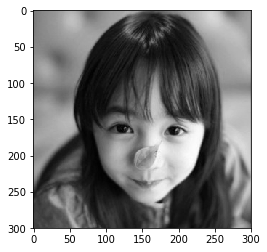

In [7]:
im = Image.open('girl.jpg').convert('L') # to gray
im = np.array(im, dtype='float32') # to matrix
imshow(im.astype('uint8'), cmap='gray');

### 1.1 2D Spatial Filtering/Convolution

#### 1.1.1 Using torch.nn.Conv2d()

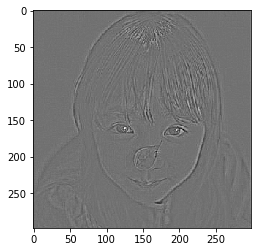

In [8]:
im = t.from_numpy(im.reshape([1, 1, im.shape[0], im.shape[1]])) # to tensor
conv1 = nn.Conv2d(1, 1, 3, bias=False)

sobel_kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype='float32') # DOG!
sobel_kernel = sobel_kernel.reshape((1, 1, 3, 3)) 
conv1.weight.data = t.from_numpy(sobel_kernel) 

edge1 = conv1(im) # convolution!
edge1 = edge1.data.squeeze().numpy() # to numpy format for visulization
imshow(edge1, cmap='gray');

#### 1.1.2 Using torch.nn.functional.conv2d()

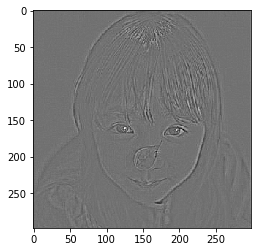

In [9]:
weight = t.from_numpy(sobel_kernel)
edge2 = F.conv2d(im, weight)
edge2 = edge2.data.squeeze().numpy() # to numpy for visulization
imshow(edge2, cmap='gray');

### 1.2 Max Pooling

#### 1.2.1 Using toruch.nn.MaxPool2d()

before max pool, image shape: 300 x 300
after max pool, image shape: 150 x 150 


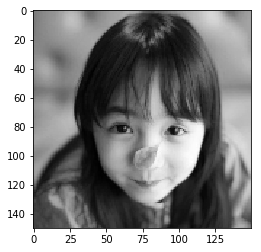

In [10]:
pool1 = nn.MaxPool2d(2, 2)
print('before max pool, image shape: {} x {}'.format(im.shape[2], im.shape[3]))
small_im1 = pool1(im)
small_im1 = small_im1.data.squeeze().numpy()
print('after max pool, image shape: {} x {} '.format(small_im1.shape[0], small_im1.shape[1]))
imshow(small_im1, cmap='gray');

#### 1.2.2 Using torch.nn.functional.max_pool2d()

before max pool, image shape: 300 x 300
after max pool, image shape: 150 x 150 


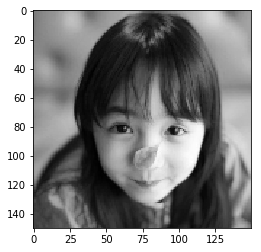

In [11]:
print('before max pool, image shape: {} x {}'.format(im.shape[2], im.shape[3]))
small_im2 = F.max_pool2d(im, 2, 2)
small_im2 = small_im2.data.squeeze().numpy()
print('after max pool, image shape: {} x {} '.format(small_im1.shape[0], small_im1.shape[1]))
imshow(small_im2, cmap='gray');

### 1.3 Data Augmentation (using torchvision's transforms)

#### 1.3.0 The original image

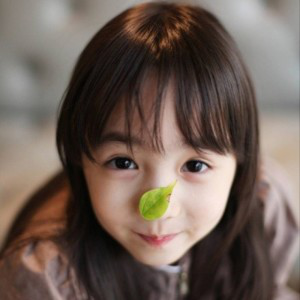

In [12]:
im = Image.open('girl.jpg')
im

#### 1.3.1 Rescaling

before scale, shape: (300, 300)
after scale, shape: (200, 100)


/Users/Kuan-Hao/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


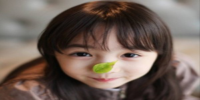

In [16]:
print('before scale, shape: {}'.format(im.size))
new_im = transforms.Scale((100, 200))(im)
print('after scale, shape: {}'.format(new_im.size))
new_im

#### 1.3.2  Cropping

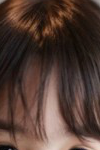

In [20]:
random_im1 = transforms.RandomCrop((150,100))(im)
random_im1

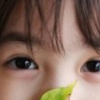

In [21]:
center_im = transforms.CenterCrop(100)(im)
center_im

#### 1.3.3 Flipping

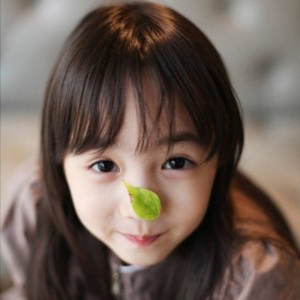

In [22]:
h_filp = transforms.RandomHorizontalFlip()(im)
h_filp

#### 1.3.4 Everything

/Users/Kuan-Hao/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


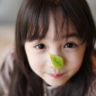

In [26]:
im_aug = transforms.Compose([
    transforms.Scale(120),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(96),
])
new_im = im_aug(im)
new_im

## 2 CIFAR-10

### 2.0 The dataset (~100MB)
<img src="https://alexisbcook.github.io/assets/cifar10.png" width=75%>

In [32]:
# Preprocessing:
data_tf = transforms.Compose([
         transforms.ToTensor(), # range [0, 255] -> [0.0,1.0]
         # normalize to [-1,1]:
         #transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), 
                             ])
train_set = CIFAR10(root='.', train=True, transform=data_tf,download=True)
train_data = t.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_set = CIFAR10(root='.', train=False, transform=data_tf)
test_data = t.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


torch.Size([3, 32, 32]) tensor(0.1176) tensor(0.9490) 8 ship
dog dog plane plane car frog horse deer bird frog ship truck ship plane plane plane deer frog plane horse plane deer deer plane dog bird truck horse horse dog deer ship bird horse truck horse horse horse cat deer truck ship ship frog plane frog horse frog truck truck horse ship deer frog cat cat plane frog plane dog car cat deer bird


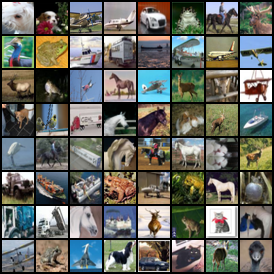

In [36]:
# Examine one image:
(data, label) = train_set[100]
print(data.size(),t.min(data),t.max(data),label,classes[label])

# Getting a batch through the data loader:
dataiter = iter(train_data)
images, labels = dataiter.next() # returning a batch 
print(' '.join('%s'%classes[labels[j]] for j in range(len(labels))))
show(tv.utils.make_grid(images))

### 2.1 LeNet
<img src=https://4.bp.blogspot.com/-Xc-1oK8cPHs/WS4aYCpsnSI/AAAAAAAADdU/jOARrMWGj3gs_pAXU-C4ryAFa8C_CuBfACLcB/s1600/fig_1_3_LeCun.png>

In [39]:
# Make the model:

class Net(nn.Module):
    def __init__(self):
        
        super(Net, self).__init__() # = nn.Module.__init__(self)
        
        self.conv1 = nn.Conv2d(3, 6, 5) # in, out, kernel
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1   = nn.Linear(16*5*5, 120) 
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): # functional expressions
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x

lenet = Net()
print(lenet)

# All learning parameters:
for name,parameters in lenet.named_parameters():
    print(name,':',parameters.size())

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
conv1.weight : torch.Size([6, 3, 5, 5])
conv1.bias : torch.Size([6])
conv2.weight : torch.Size([16, 6, 5, 5])
conv2.bias : torch.Size([16])
fc1.weight : torch.Size([120, 400])
fc1.bias : torch.Size([120])
fc2.weight : torch.Size([84, 120])
fc2.bias : torch.Size([84])
fc3.weight : torch.Size([10, 84])
fc3.bias : torch.Size([10])


In [45]:
# Training:
optimizer = optim.Adam(lenet.parameters())
criterion = nn.CrossEntropyLoss()
train(device, lenet, train_data, test_data, 5, optimizer, criterion)

NameError: name 'train' is not defined

### 2.2 AlexNet
<img src="https://2.bp.blogspot.com/-scAJz-H9v4Y/WVj7Nl-YtNI/AAAAAAAAJss/1pdBtFPg7IUv0thtU-I5KBeX2a3Si5pXQCLcBGAs/s1600/alexnet_2.png">

#### 2.2.1 The original

In [46]:
alexnet=models.alexnet()
#??models.alexnet #try to use %load to examine the source code
print(alexnet)

# All learning parameters:
for name,parameters in alexnet.named_parameters():
    print(name,':',parameters.size())

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

#### 2.2.2 The customized

In [47]:
class MyAlexNet(nn.Module):

    def __init__(self, num_classes=10):
        super(MyAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

alexnet=MyAlexNet()

In [48]:
optimizer = optim.Adam(alexnet.parameters())
criterion = nn.CrossEntropyLoss()
train(device, alexnet, train_data, test_data, 5, optimizer, criterion)

NameError: name 'train' is not defined

### 2.3 Visual Geometry Group (VGG)
<img src="https://qph.ec.quoracdn.net/main-qimg-e657c195fc2696c7d5fc0b1e3682fde6">
<img src="https://cdn-images-1.medium.com/max/1600/0*HREIJ1hjF7z4y9Dd.jpg" width=50%>

#### 2.3.1 The original

In [49]:
vgg16=models.vgg16()
vgg16_bn=models.vgg16_bn()
print(vgg16)
print(vgg16_bn)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

#### 2.3.2 The customized

In [50]:
#Building blocks:

def vgg_block(num_convs, in_channels, out_channels):
    net = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.ReLU(True)] #1st layer
    
    for i in range(num_convs-1): 
        net.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
        net.append(nn.ReLU(True))
        
    net.append(nn.MaxPool2d(2, 2))
    return nn.Sequential(*net)

def vgg_stack(num_convs, channels):
    net = []
    for n, c in zip(num_convs, channels):
        in_c = c[0]
        out_c = c[1]
        net.append(vgg_block(n, in_c, out_c))
    return nn.Sequential(*net)

In [51]:
# Testing model blocks:
block_demo = vgg_block(3, 64, 128)
print(block_demo)
input_demo = t.zeros(1, 64, 300, 300)
output_demo = block_demo(input_demo)
print(output_demo.shape)

# Testing the VGG core:
vgg_net = vgg_stack((1, 1, 2, 2, 2), ((3, 64), (64, 128), (128, 256), (256, 512), (512, 512)))
print(vgg_net)
test_x = t.zeros(1, 3, 256, 256)
test_y = vgg_net(test_x)
print(test_y.shape)

# Constructing the full model:
class vgg(nn.Module):
    def __init__(self):
        super(vgg, self).__init__()
        self.feature = vgg_net
        self.fc = nn.Sequential(
            nn.Linear(512, 100),
            nn.ReLU(True),
            nn.Linear(100, 10)
        )
    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

vggnet=vgg()

if(t.cuda.is_available()):
    vggnet=vggnet.cuda()
    
print(vggnet)

Sequential(
  (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
torch.Size([1, 128, 150, 150])
Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(256, 256, kernel_size=(3, 3),

In [52]:
# Training:
optimizer = optim.Adam(vggnet.parameters())
criterion = nn.CrossEntropyLoss()
train(device, vggnet, train_data, test_data, 5, optimizer, criterion)

NameError: name 'train' is not defined

### 2.4 Residual Net (ResNet)

<img src="http://lanbing510.info/public/img/posts/resnet/4.gif">
<img src="http://lanbing510.info/public/img/posts/resnet/3.png" width=50%>
<img src="http://lanbing510.info/public/img/posts/resnet/2.png">

#### 2.4.1 The original

In [53]:
resnet=models.resnet18() # try resnet34, resnet50, etc.
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

#### 2.4.2 The customized (not finished yet)

In [54]:
# Building blocks:

class residual_block(nn.Module):
    def __init__(self, in_channel, out_channel, same_shape=True):
        super(residual_block, self).__init__()
        self.same_shape = same_shape
        stride=1 if self.same_shape else 2
        
        self.conv1 = nn.Conv2d(in_channel, out_channel, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        
        self.conv2 = nn.Conv2d(in_channel, out_channel, 3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        if not self.same_shape:
            self.conv3 = nn.Conv2d(in_channel, out_channel, 1, stride=stride)
        
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(self.bn1(out), True)
        out = self.conv2(out)
        out = F.relu(self.bn2(out), True)
        
        if not self.same_shape:
            x = self.conv3(x)
        return F.relu(x+out, True)
    
# Testing the block: same input/output dimensions:
test_net = residual_block(32, 32)
test_x = t.zeros(1, 32, 96, 96)
print('input: {}'.format(test_x.shape))
test_y = test_net(test_x)
print('output: {}'.format(test_y.shape))

input: torch.Size([1, 32, 96, 96])
output: torch.Size([1, 32, 96, 96])


In [55]:
class resnet(nn.Module):
    
    def __init__(self, in_channel, num_classes, verbose=False):
        super(resnet, self).__init__()
        self.verbose = verbose
        
        self.block1 = nn.Conv2d(in_channel, 64, 7, 2)
        
        self.block2 = nn.Sequential(
            nn.MaxPool2d(3, 2),
            residual_block(64, 64),
            residual_block(64, 64)
        )
        
        self.block3 = nn.Sequential(
            residual_block(64, 128, False),
            residual_block(128, 128)
        )
        
        self.block4 = nn.Sequential(
            residual_block(128, 256, False),
            residual_block(256, 256)
        )
        
        self.block5 = nn.Sequential(
            residual_block(256, 512, False),
            residual_block(512, 512),
            nn.AvgPool2d(3)
        )
        
        self.classifier = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.block1(x)
        if self.verbose:
            print('block 1 output: {}'.format(x.shape))
        x = self.block2(x)
        if self.verbose:
            print('block 2 output: {}'.format(x.shape))
        x = self.block3(x)
        if self.verbose:
            print('block 3 output: {}'.format(x.shape))
        x = self.block4(x)
        if self.verbose:
            print('block 4 output: {}'.format(x.shape))
        x = self.block5(x)
        if self.verbose:
            print('block 5 output: {}'.format(x.shape))
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

### 2.5 Inception

#### 2.5.1 The original

#### 2.5.2 The customized